In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load data
data = pd.read_csv('data_with_all_scores_scaled.csv')

In [3]:
# Show first few rows to understand the data
print("First 5 rows of the data:")
print(data.head())

First 5 rows of the data:
          Player Name  Age                 Team   ASR Nationality  \
0          Abdu Conté   27           Young Boys  6.58         POR   
1  Abduqodir Khusanov   21      Manchester City  7.01         UZB   
2           Abel Ruiz   25            Girona FC  6.65         ESP   
3       Achraf Hakimi   26  Paris Saint-Germain  7.63         MAR   
4         Adam Daghim   19    Red Bull Salzburg  6.97         DEN   

   Transfer History Count  MarketValue  missing_market_value  Age_norm  \
0                       5       750000                 False    0.7075   
1                       3     11400000                 False    0.5725   
2                       5      5700000                 False    0.6625   
3                       5     62000000                 False    0.6850   
4                       4      5400000                 False    0.5275   

   MarketValue_norm  Transfers_norm  Nationality_norm  ClubTier  \
0          0.103041            0.40            

In [4]:
# Define target and features
target = 'SustainabilityScore'

In [5]:
# Include missing_market_value as a feature (convert boolean to int)
data['missing_market_value'] = data['missing_market_value'].astype(int)

In [6]:
# Features for the model
features = ['ASR', 'Age_norm', 'MarketValue_norm', 'Transfers_norm', 'Nationality_norm', 'ClubTier_norm']

In [7]:
# Check for missing values in these columns and drop rows with missing data
print("\nMissing values per feature before dropping rows:")
print(data[features + [target]].isnull().sum())

data = data.dropna(subset=features + [target])


Missing values per feature before dropping rows:
ASR                    0
Age_norm               0
MarketValue_norm       0
Transfers_norm         0
Nationality_norm       0
ClubTier_norm          0
SustainabilityScore    0
dtype: int64


In [8]:
# Separate features and target
X = data[features]
y = data[target]

In [9]:
# Split the data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Initialize Random Forest Regressor and train it
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [11]:
# Predict on test data
y_pred = rf_model.predict(X_test)

In [12]:
# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"\nModel Performance:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared Score (R2): {r2:.4f}")



Model Performance:
Mean Squared Error (MSE): 0.2609
R-squared Score (R2): 0.9869


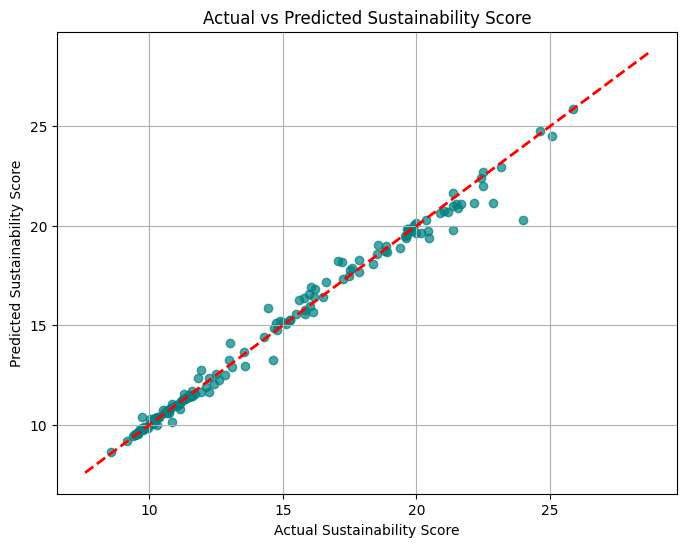

In [13]:
# Plot actual vs predicted Sustainability Score to visualize performance
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.7, color='teal')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel("Actual Sustainability Score")
plt.ylabel("Predicted Sustainability Score")
plt.title("Actual vs Predicted Sustainability Score")
plt.grid(True)
plt.show()


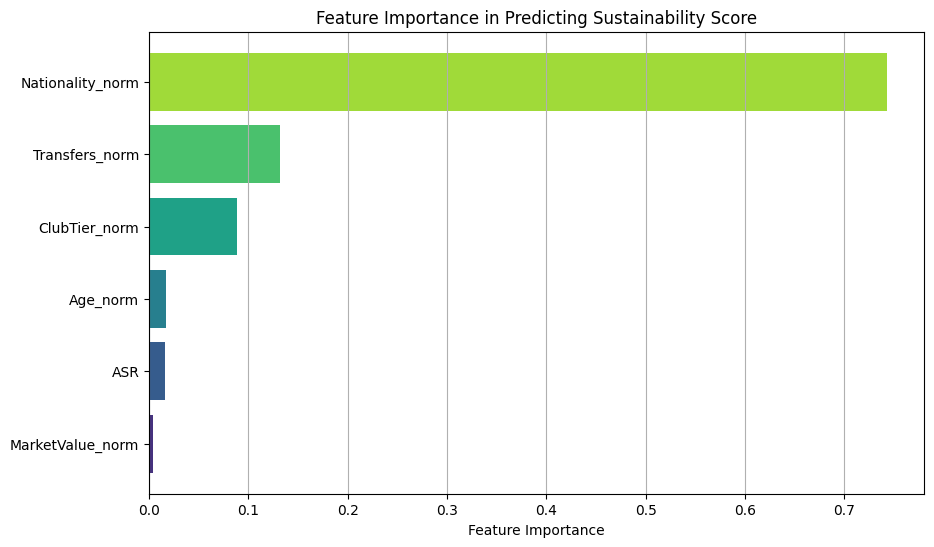


Feature importance shows which features the model relied on most to make predictions. Higher values mean the feature contributes more to the prediction.


In [14]:
# Plot feature importances with explanations
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=True)

plt.figure(figsize=(10,6))
colors = sns.color_palette('viridis', len(features))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color=colors)
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Predicting Sustainability Score')
plt.grid(axis='x')
plt.show()

print("\nFeature importance shows which features the model relied on most to make predictions. "
      "Higher values mean the feature contributes more to the prediction.")

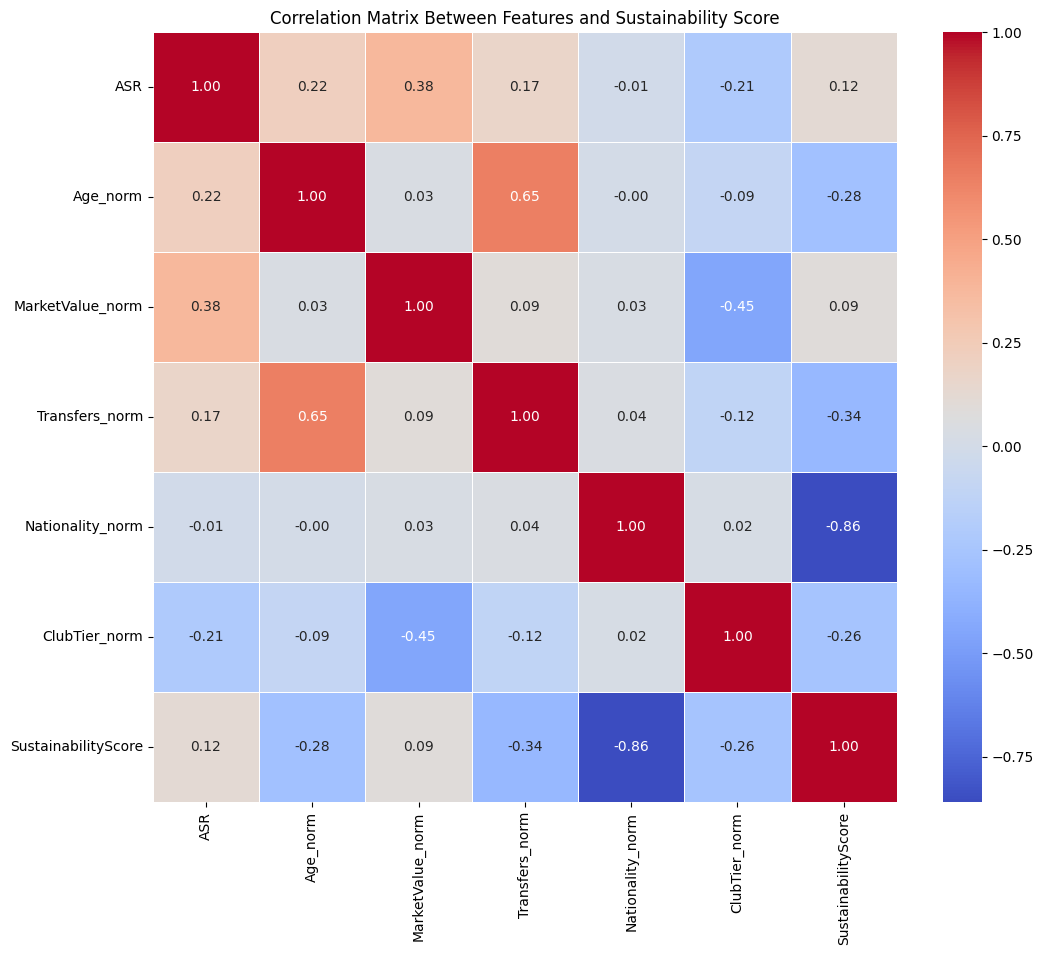


Correlation matrix helps identify linear relationships between variables. Strong positive or negative correlations might help model prediction.


In [16]:
# Visualize correlation heatmap between features and target
plt.figure(figsize=(12,10))
corr_matrix = data[features + [target]].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix Between Features and Sustainability Score")
plt.show()

print("\nCorrelation matrix helps identify linear relationships between variables. "
      "Strong positive or negative correlations might help model prediction.")

In [19]:


# --- Normalization helper ---
def normalize(value, min_val, max_val):
    return 0.1 + 0.9 * ((value - min_val) / (max_val - min_val))

# --- Manual sustainability score calculator and predictor ---
def evaluate_player_sustainability(asr, age, market_value, transfers, nationality, club_tier, rf_model):
    """
    Compare manual vs ML predicted Sustainability Score for a new player.
    
    Parameters:
        - asr: float, Average SofaScore Rating
        - age: int, Age in years
        - market_value: int, Market value in euros
        - transfers: int, Number of transfers
        - nationality: str, 'european' or 'non-european'
        - club_tier: int, 1 (top), 2 (mid), or 3 (low)
        - rf_model: trained RandomForestRegressor model
    """
    
    # --- Define static min/max for normalization ---
    age_min, age_max = 0, 40
    mv_min, mv_max = 0, 222_000_000
    tr_min, tr_max = 0, 15
    tier_min, tier_max = 1, 3
    
    # --- Normalize inputs ---
    age_norm = normalize(age, age_min, age_max)
    mv_norm = normalize(market_value, mv_min, mv_max)
    tr_norm = normalize(transfers, tr_min, tr_max)
    nat_norm = 0.1 if nationality.lower() == 'european' else 1.0
    club_norm = normalize(club_tier, tier_min, tier_max)

    # --- Define weights (same as your input score logic) ---
    weight_age = 0.2
    weight_market = 0.04
    weight_transfers = 0.32
    weight_nationality = 0.28
    weight_clubtier = 0.16

    # --- Calculate InputScore manually ---
    input_score = (
        weight_age * age_norm +
        weight_market * mv_norm +
        weight_transfers * tr_norm +
        weight_nationality * nat_norm +
        weight_clubtier * club_norm
    )

    # --- Manually compute sustainability score ---
    manual_score = asr / input_score

    # --- Prepare input for ML prediction ---
    new_player = pd.DataFrame([{
        'ASR': asr,
        'Age_norm': age_norm,
        'MarketValue_norm': mv_norm,
        'Transfers_norm': tr_norm,
        'Nationality_norm': nat_norm,
        'ClubTier_norm': club_norm
    }])

    # --- Predict with trained ML model ---
    predicted_score = rf_model.predict(new_player)[0]

    # --- Print results ---
    print("🔍 Player Info:")
    print(f"Age: {age}, Market Value: €{market_value}, Transfers: {transfers}, Nationality: {nationality}, Club Tier: {club_tier}")
    print("\n📈 Scores:")
    print(f"✅ Manual Sustainability Score: {manual_score:.3f}")
    print(f"🧠 Predicted by ML Model:       {predicted_score:.3f}")
evaluate_player_sustainability(
    asr=7.31,
    age=24,
    market_value=208_000_000,
    transfers=2,
    nationality='brazil',
    club_tier=1,
    rf_model=rf_model  # your trained model from earlier
)


🔍 Player Info:
Age: 24, Market Value: €208000000, Transfers: 2, Nationality: brazil, Club Tier: 1

📈 Scores:
✅ Manual Sustainability Score: 13.737
🧠 Predicted by ML Model:       12.849
